In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [1]:
!pip install d2l

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 106.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 417.2 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 3.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 597.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 329.9 kB/s eta 0:00:000:01
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0
  Attempting uninstall: numpy
    Found existing installation: 

In [2]:
import warnings
from d2l import paddle as d2l

warnings.filterwarnings("ignore")
import paddle
import paddle.nn as nn
from paddle.nn import functional as F


class Residual(nn.Layer):  #@save
    def __init__(self, input_channels, num_channels, use_1x1conv=False,
                 strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2D(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2D(num_channels, num_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2D(num_channels)
        self.bn2 = nn.BatchNorm2D(num_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [3]:
blk = Residual(3, 3)
X = paddle.rand([4, 3, 6, 6])
Y = blk(X)
Y.shape

W0206 14:03:32.443981   224 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0206 14:03:32.447649   224 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


[4, 3, 6, 6]

In [4]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

[4, 6, 3, 3]

In [5]:
b1 = nn.Sequential(nn.Conv2D(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2D(64), nn.ReLU(),
                   nn.MaxPool2D(kernel_size=3, stride=2, padding=1))

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2D((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = paddle.rand(shape=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 [1, 64, 56, 56]
Sequential output shape:	 [1, 64, 56, 56]
Sequential output shape:	 [1, 128, 28, 28]
Sequential output shape:	 [1, 256, 14, 14]
Sequential output shape:	 [1, 512, 7, 7]
AdaptiveAvgPool2D output shape:	 [1, 512, 1, 1]
Flatten output shape:	 [1, 512]
Linear output shape:	 [1, 10]


loss 0.010, train acc 0.999, test acc 0.907
4503.2 examples/sec on Place(gpu:0)


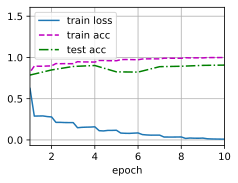

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 